In [14]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk

import os

# Enabling eager execution 

In [15]:
tf.enable_eager_execution()

# Load Glove vectors

In [16]:
UNK = '</s>'

dirname = os.getcwd()
googlePath = os.path.join(dirname, 'datasets/')
outfile = googlePath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(googlePath+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)
print(googleSet.shape)
print(googleSet.head())

googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]

(1965717, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  


In [17]:
#UNK = '<unk>'

#glovePath = '/media/kandy/hdd/master-thesis/datasets/'
#outfile = glovePath +'glove_word_corpus.pic'

#with open(outfile, 'rb') as pickle_file:    
#    gloveCorpus, glove_corpus_word_to_int, glove_corpus_int_to_word = pickle.load(pickle_file)
#gloveSet = pd.read_csv(glovePath+'glove.42B.10d.txt', sep=' ', header=None)
#print(gloveSet.shape)
#print(gloveSet.head())

#gloveWords = gloveSet.iloc[:,0:1]
#gloveVectors = gloveSet.iloc[:,1:]

# Load training and test dataset

In [18]:
treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

treeDataframe.head()

,sentence,tree
0,pierre </s> </s> </s> years old </s> will join...,"[[[(</s> (</s> pierre) (</s> vinken)), (</s> <..."
1,</s> </s> is chairman </s> </s> </s> </s> the ...,"[[[(</s> mr</s>), (</s> vinken)], [(</s> is), ..."
2,</s> </s> </s> </s> years old </s> former chai...,"[[[(</s> (</s> rudolph) (</s> agnew)), (</s> <..."
3,</s> form </s> asbestos once used * * </s> mak...,[[[(</s>\n (</s>\n (</s> (</s> a) (</s> fo...
4,the asbestos fiber </s> </s> </s> is unusually...,[[[(</s>\n (</s> (</s> the) (</s> asbestos) (...


In [20]:
def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)
treeDataframe_num.head()

,sentence,tree
0,"[353287, 920150, 920150, 920150, 1131873, 1851...","[[[(</s> (</s> pierre) (</s> vinken)), (</s> <..."
1,"[920150, 920150, 1025196, 261666, 920150, 9201...","[[[(</s> mr</s>), (</s> vinken)], [(</s> is), ..."
2,"[920150, 920150, 920150, 920150, 1131873, 1851...","[[[(</s> (</s> rudolph) (</s> agnew)), (</s> <..."
3,"[920150, 1751421, 920150, 151538, 26198, 83139...",[[[(</s>\n (</s>\n (</s> (</s> a) (</s> fo...
4,"[1323513, 151538, 1349057, 920150, 920150, 920...",[[[(</s>\n (</s> (</s> the) (</s> asbestos) (...


In [21]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.999)
print(treeDF_train.shape)
print(treeDF_test.shape)

(49, 2)
(49159, 2)


# Model and the Parameters

In [22]:
STATE_SIZE = 10
embeddings = tfe.Variable(name='embeddings', validate_shape= googleVectors.shape, 
                          initial_value=googleVectors.values, 
                          dtype=tf.float32, trainable=False)
w = tfe.Variable(name='w', validate_shape=(2*googleVectors.shape[1], STATE_SIZE), 
                 initial_value=0.01 * tf.random_normal(shape=(2*googleVectors.shape[1], STATE_SIZE)),
                 dtype=tf.float32)
b = tfe.Variable(name='b', validate_shape=(1, STATE_SIZE),
                 initial_value=0.01 * tf.random_normal(shape=(1, STATE_SIZE)),
                 dtype=tf.float32)

w_score = tfe.Variable(name='w_score', validate_shape=(STATE_SIZE, 1), 
                 initial_value=0.01 * tf.random_normal(shape=(STATE_SIZE, 1)),
                 dtype=tf.float32)
b_score = tfe.Variable(name='b_score', validate_shape=(1, 1),
                 initial_value=0.01 * tf.random_normal(shape=(1, 1)),
                 dtype=tf.float32)

#print(w)
#print(b)
#print(w_score)
#print(b_score)

In [23]:
print(embeddings.shape)
lookup = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int['</s>'])
lookup = tf.reshape(lookup, shape=(1, lookup.shape[0]))
print(lookup)

(1965717, 10)
tf.Tensor(
[[ 0.09570312 -0.03881836  0.05883789  0.03930664 -0.01300049 -0.1484375
   0.07568359 -0.13378906  0.2890625   0.00370789]], shape=(1, 10), dtype=float32)


In [24]:
def compute_score_for_tree(tree, weights, embeddings, scores):
    if(type(tree[0]) == type('a string')):
        #print(tree.label() + ' : ' + tree[0])
        word = tree[0].lower()
        if(word not in google_corpus_word_to_int):
            #print('missing word:',word)
            word = '</s>'
        word_vector = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int[word])
        word_vector = tf.reshape(word_vector, shape=(1, word_vector.shape[0]))
        return word_vector
        #print('depth is reached !!!')
        #return

    #for i in range(len(tree)):
    #    print('Inside tree : '+ tree[i].label())
    #    compute_score_for_tree(tree[i], weights, embeddings)


        
    left = compute_score_for_tree(tree[0], weights, embeddings, scores)
    if(len(tree) !=2):
        return left

    right = compute_score_for_tree(tree[1], weights, embeddings, scores)
    words_concat = tf.concat([left, right], axis=0)
    #print(words_concat.shape)
    #print(left.shape, right.shape)
    words_concat = tf.reshape(words_concat, shape=(1, left.shape[1] + right.shape[1]))
    #print(words_concat)
    z = tf.matmul(words_concat, weights[0]) + weights[1]
    state_vec = tf.tanh(z)
    
    #print(state_vec)
    score = tf.matmul(state_vec, weights[2]) + weights[3]
    scores.append(score)
    return state_vec
    
    
for j in range(treeDF_train.shape[0]):
    tree = treeDF_train.iat[j,1]
    print(tree.leaves())
    scores = []
    tree.chomsky_normal_form()
    compute_score_for_tree(tree[0], [w,b,w_score,b_score], embeddings, scores)
    #print(sum(scores))
    total_score = tf.reduce_sum(tf.stack(scores))
    print(total_score)
    break
    


['</s>', 'i', 'agree', '</s>', 'it', "'s", 'ridiculous', '</s>', '</s>', 'says', '*t*-2', 'mr</s>', 'boren', '</s>', 'and', 'indeed', 'by', 'now', 'ridiculous', 'may', 'be', 'the', 'only', 'way', '0', '*', 'to', 'describe', 'how', 'the', 'u</s></s></s>', 'decides', '*-4', 'to', 'take', '*rnr*-1', '--', 'or', 'rather', '</s>', '*-4', 'not', 'to', 'take', '*rnr*-1', '--', 'covert', 'action', '*t*-5', '*t*-3', '</s>']
tf.Tensor(-0.21450391, shape=(), dtype=float32)


In [25]:
def compare_trees(actual, predicted):
    actual_sub_trees = actual.subtrees()
    
    
    total_count = 0.0 #len(actual_sub_trees)
    match_count = 0.0
    
    for sub_tree in actual_sub_trees:
        #print('Sub Tree:', sub_tree)
        #print(predicted_sub_trees)
        predicted_sub_trees = predicted.subtrees()
        for temp_tree in predicted_sub_trees:
            #print(' ', temp_tree)
            if(sub_tree == temp_tree):
                match_count = match_count + 1.0
                break
        total_count = total_count + 1.0
        #break
    #print('Match:', match_count,' Total:', total_count)
    
    return [match_count/total_count, match_count, total_count]

#compare_trees(treeDF_train.iat[2,1], treeDF_train.iat[2,1])

t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
sub_trees = t1.subtrees()
for sub_tree in sub_trees:
    print(sub_tree)

(S (NP I) (VP (V saw) (NP him)))
(NP I)
(VP (V saw) (NP him))
(V saw)
(NP him)


In [26]:
#t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
#t2 = nltk.Tree.fromstring("(a (b I) (c (d saw) (e him)))")

#compare_trees(t1, t2)

In [27]:
start = timer()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
epoch = 1

# history to maintain variables,  losses and gradients
variables_history = []
variables_history.append([np.copy(w.numpy()), np.copy(b.numpy()),np.copy(w_score.numpy()),np.copy(b_score.numpy())])

loss_history = []
grad_history = []

for i in range(epoch):
    # to record the history of tensor computations
    total_train_score = 0.0
    total_train_count = 0.0
    print('Epoch : ', i)
    with tf.GradientTape() as tape:
        # watching - is it necessary ???
        #tape.watch([w,b,w_score,b_score])
        for j in range(treeDF_train.shape[0]):
            #print(j)
            # get the word vectors based on the word ids (word id for each word)
            words = tf.nn.embedding_lookup(embeddings, treeDF_train.iat[j,0])
            end = timer()
            #print('Time taken to lookup embeddings (seconds): ', end-start)
            #words matrix - unstack
            words_unstack = tf.unstack(words)
            words_len = len(words_unstack)
            pred_score_list = []
            total_loss_list = []
            predicted_tree = [nltk.Tree(UNK,[google_corpus_int_to_word[index]]) for index in treeDF_train.iat[j,0]]
            
            #loop until all the words are merged together
            while(words_len > 1):
                #compute scores for the list of word combinations
                # for each word combination compute the score of it
                scores = np.zeros(shape=(words_len-1, 1))
                for k in range(words_len - 1):
                    words_concat = tf.concat([words_unstack[k], words_unstack[k+1]], axis=0)
                    #reshape the tensor to be a matrix with 1 row rather than vector
                    words_concat = tf.reshape(words_concat, shape=(1, words_concat.shape[0]))
                    # matrix computation and activation
                    z = tf.matmul(words_concat, w) + b
                    state_vec = tf.tanh(z)
                    score = tf.matmul(state_vec, w_score) + b_score
                    scores[k] = score
                end = timer()
                #print('Time taken to calculate all subsequent word combinations (seconds): ', end-start)
                #print(scores)
                #compare the scores and pick the maximum one. 
                max_score_index = np.argmax(scores) 
                pred_score_list.append(scores[max_score_index])
                
                # remove the words which is used to combine and replace with combined state vector
                words_unstack.pop(max_score_index+1)
                words_unstack.pop(max_score_index)
                # statevector needs to be reshaped as matrix to update
                state_vec_vector = tf.reshape(state_vec, shape = [state_vec.shape[1]])
                words_unstack.insert(max_score_index, state_vec_vector)
                words_len = len(words_unstack)
                
                right_tree = predicted_tree.pop(max_score_index+1)
                left_tree = predicted_tree.pop(max_score_index)
                predicted_tree.insert(max_score_index, nltk.Tree(UNK, [left_tree, right_tree]))
                
                end = timer()
                #print('Time taken to make one decision (seconds): ', end-start)
            end = timer()
            #print('Time taken to forward loop (seconds): ', end-start)
            # get the actual tree - convert it to chomsky normal form, and compute the score
            act_score_list = []
            tree = treeDF_train.iat[j,1]
            tree.chomsky_normal_form()
            compute_score_for_tree(tree[0], [w,b,w_score,b_score], embeddings, act_score_list)
            end = timer()
            #print('Time taken to chomsky calculation (seconds): ', end-start)
            
            # compute the total actual and predicted score. use the loss function as absolute difference
            # the above is done for each training data and the loss are accumulated
            total_act_score = tf.reduce_sum(tf.stack(act_score_list))
            total_pred_score = tf.reduce_sum(tf.stack(pred_score_list))
            loss = tf.losses.absolute_difference(total_act_score,  total_pred_score)
            total_loss_list.append(loss)
            #loss = tf.losses.sigmoid_cross_entropy(tf.constant(imdb_train.iat[j,1], shape=(1,1)), y_predict)
            
            total_train_score = total_train_score + compare_trees(tree[0], predicted_tree[0])[0]
            total_train_count = total_train_count + 1
            
        #compute the average losses accompanying all training data
        # compute the gradients and apply them on variables
        total_loss = tf.reduce_mean(tf.stack(total_loss_list))
        grads = tape.gradient(total_loss, [w,b,w_score,b_score])
        #print(w[0])
        grad_op = optimizer.apply_gradients(zip(grads, [w,b,w_score,b_score]), 
                                  global_step=tf.train.get_or_create_global_step())
        #print(w[0])
        #maintain the history of variables, losses and gradients
        variables_history.append([np.copy(w.numpy()), np.copy(b.numpy()),np.copy(w_score.numpy()),np.copy(b_score.numpy())])
        loss_history.append(np.copy(total_loss.numpy()))
        grad_history.append([np.copy(grad.numpy()) for grad in grads])
        #print(tf.train.get_or_create_global_step().numpy(),total_loss.numpy())
        print('Training Accuracy : ', total_train_score/total_train_count)
        
    
end = timer()
print('Time taken to execute (seconds): ', end-start)

Epoch :  0
Training Accuracy :  0.4021814185297883
Time taken to execute (seconds):  11.99361278500146


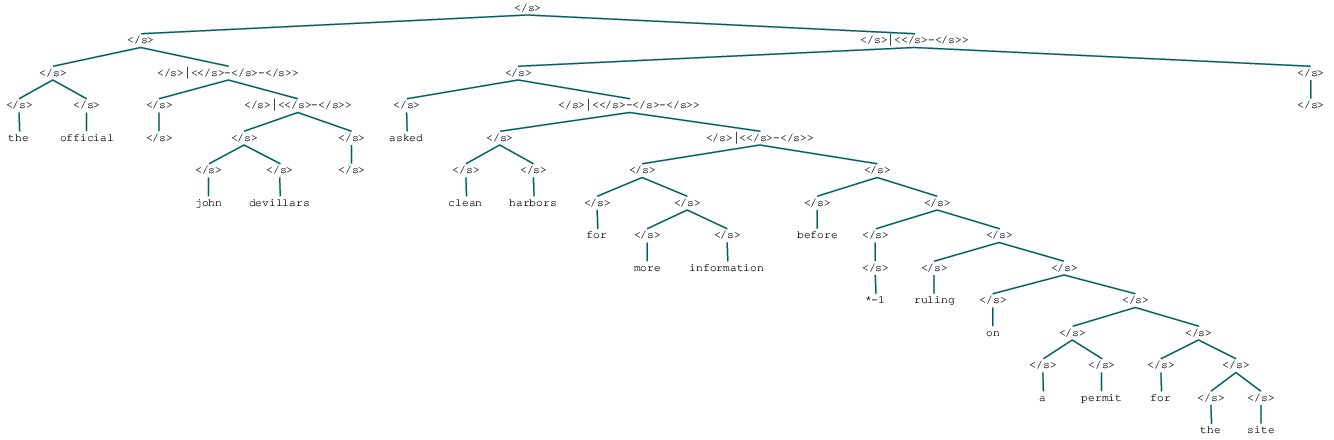

In [28]:
tree[0]

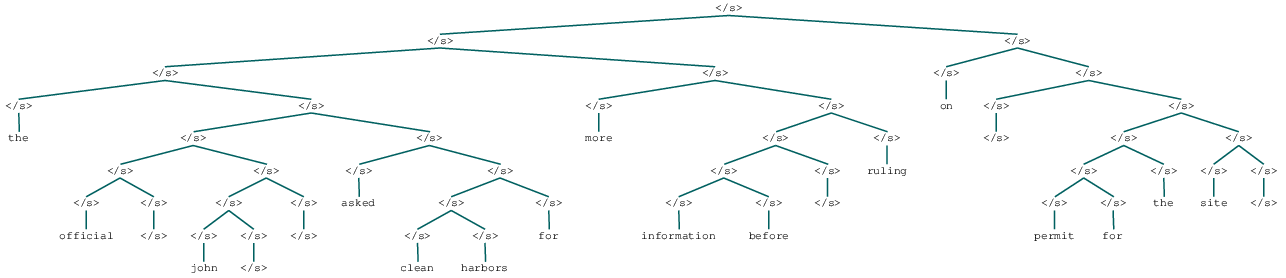

In [29]:
predicted_tree[0]

In [30]:
compare_trees(tree[0], predicted_tree[0])

[0.45454545454545453, 20.0, 44.0]

In [31]:
' '.join(tree[0].leaves())

'the official </s> john devillars </s> asked clean harbors for more information before *-1 ruling on a permit for the site </s>'

* Improve parallelization through batch processing
* Implement CMY algorithm to reuse the computed values
* Preprocessing of tree (binary children, UNK words)

* check for this tree ('morgenzon has long been a special domain of afrikanerdom </s>')
* still missing word in compute_score_for_tree function. why? All preprocessign are good
* Other hyper parameters

* GPU usage

* Increase no. of units
* BEAM search
* Involve the classification of subcategories
* Assign different weights for different subcategories (atleast broader)